Modeling the dependence of disease status on somatic variant features and clinical variables.

In [13]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import readVCF
from matplotlib import pyplot as plt
import pandas as pd
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import Logit
from patsy import dmatrices

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Statistical analysis of somatic variants

Logistic regression with $\mathrm{Dx} = 1$ for SCZ and $\mathrm{Dx} = 0$ for control.
$$
\mathrm{Dx} \sim \mathrm{Age} + \mathrm{Ancestry}_1 + ... + \text{vcf_score}_1 + ... + \text{vcf_score}_v +  \mathrm{cons}_1 + ... + \text{epigen_state} + \text{ATAC_seq}
$$

Remarks:
* to increase power technical/nuisance variables may be modeled with random effects
* lenient filtering of VCFs (by Taejeong et al) would afford higher recall

## Toy data set

The following classic data set and workflow comes from the [Getting Started page](https://www.statsmodels.org/stable/gettingstarted.html) of `statsmodels` v0.11.1.

In [2]:
guerry = sm.datasets.get_rdataset("Guerry", "HistData").data
guerry = guerry[['Department', 'Lottery', 'Literacy', 'Wealth', 'Region']]
guerry = guerry.dropna()
guerry

,Department,Lottery,Literacy,Wealth,Region
0,Ain,41,37,73,E
1,Aisne,38,51,22,N
2,Allier,66,13,61,C
3,Basses-Alpes,80,46,76,E
4,Hautes-Alpes,79,69,83,E
...,...,...,...,...,...
80,Vendee,68,28,56,W
81,Vienne,40,25,68,W
82,Haute-Vienne,55,13,67,C
83,Vosges,14,62,82,E


Create design matrices with `patsy`, choose model class to be OLS and fit the model.

In [3]:
y_g, X_g = dmatrices('Lottery ~ Literacy + Wealth + Region', data=guerry, return_type='dataframe')
mod_g = sm.OLS(y_g, X_g)
res_g = mod_g.fit()
res_g.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Lottery   R-squared:                       0.338
Model:                            OLS   Adj. R-squared:                  0.287
Method:                 Least Squares   F-statistic:                     6.636
Date:                Wed, 05 Aug 2020   Prob (F-statistic):           1.07e-05
Time:                        08:31:52   Log-Likelihood:                -375.30
No. Observations:                  85   AIC:                             764.6
Df Residuals:                      78   BIC:                             781.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      38.6517      9.456      4.087      0.000      19.826      57.478
Region[T.E]   -15.4278      9.727     -1.586      0.117     -34.793       3.938
Region[T.N]   -10.0170      9.260     -1.082      0.283     -28.453       8.419
Region[T.S]    -4.5483      7.279     -0.625      0.534     -19.039       9.943
Region[T.W]   -10.0913      7.196     -1.402      0.165     -24.418       4.235
Literacy       -0.1858      0.210     -0.886      0.378      -0.603       0.232
Wealth          0.4515      0.103      4.390      0.000       0.247       0.656
==============================================================================
Omnibus:                        3.049   Durbin-Watson:                   1.785
Prob(Omnibus):                  0.218   Jarque-Bera (JB):                2.694
Skew:                          -0.340   Prob(JB):                        0.260
Kurtosis:                       2.454   Cond. No.                         371.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Our data set

In [4]:
calls = readVCF.readVCFs()
repr(list(calls.columns))

Welcome, Attila Jones!



"['CHROM', 'POS', 'REF', 'ALT', 'QUAL', 'FILTER/PASS', 'FILTER/HC', 'FILTER/EXT', 'AC', 'AF', 'AN', 'BaseQRankSum', 'DP', 'DS', 'END', 'ExcessHet', 'FS', 'InbreedingCoeff', 'MLEAC', 'MLEAF', 'MQ', 'MQRankSum', 'NEGATIVE_TRAIN_SITE', 'POSITIVE_TRAIN_SITE', 'QD', 'RAW_MQandDP', 'ReadPosRankSum', 'SOR', 'VQSLOD', 'culprit', 'ChromatinState_DLPFC', 'SiPhyLOD', 'SiPhyBranchLen', 'szdbCNVcount', 'GWASpval', 'chromatinState_DLPFC', 'evolConstrain', 'Sample', 'Individual ID', 'Tissue', 'Individual Notes', 'Institution', 'Brain ID', 'SCZ Pair', 'BP Pair', 'Changed (used Affy phenotype)', 'Reported Gender', 'Sex', 'Ethnicity', 'Race', 'Genotype Inferred Ancestry', 'ageOfDeath', 'Date of Death', 'Time of Death', 'Time of Death (Military)', 'Autopsy ID', 'Brain Weight (in grams)', 'PMI (in hours)', 'pH', 'Dx', 'primaryDiagnosisDetail', 'Presence or Absence of Dementia (Y/N)', 'CDR', 'Year of Autopsy', 'Neuropath', 'Neuropath desc', 'Gross Diagnosis', 'Benzodiazepines', 'Anticonvulsants', 'Antipsyc

In [5]:
calls = calls[['Dx', 'AF', 'szdbCNVcount', 'ageOfDeath', 'Sex']]
calls

,Dx,AF,szdbCNVcount,ageOfDeath,Sex
0,Control,0.06,1,94.0,XX
1,Control,0.02,2,94.0,XX
2,Control,0.02,0,94.0,XX
3,Control,0.04,8,94.0,XX
4,Control,0.04,4,94.0,XX
...,...,...,...,...,...
37,SCZ,0.02,1,71.0,XX
38,SCZ,0.04,1,71.0,XX
39,SCZ,0.20,0,71.0,XX
40,SCZ,0.04,0,71.0,XX


In [6]:
y, X = dmatrices('Dx ~ AF + szdbCNVcount + ageOfDeath + Sex', data=calls, return_type='dataframe')
y = y['Dx[SCZ]']

### Normal linear model

In [7]:
mod = sm.OLS(y, X)
res_nlm = mod.fit()
res_nlm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Dx[SCZ]   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.226
Date:                Wed, 05 Aug 2020   Prob (F-statistic):              0.299
Time:                        08:31:54   Log-Likelihood:                -250.12
No. Observations:                 410   AIC:                             510.2
Df Residuals:                     405   BIC:                             530.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.4210      0.135      3.120      0.002       0.156       0.686
Sex[T.XY]       -0.0500      0.052     -0.957      0.339      -0.153       0.053
AF               0.3775      0.271      1.393      0.164      -0.155       0.910
szdbCNVcount    -0.0066      0.006     -1.134      0.258      -0.018       0.005
ageOfDeath      -0.0017      0.001     -1.182      0.238      -0.005       0.001
==============================================================================
Omnibus:                      125.295   Durbin-Watson:                   0.068
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               82.024
Skew:                           0.977   Prob(JB):                     1.54e-18
Kurtosis:                       2.010   Cond. No.                         957.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Logistic regression

In [8]:
res = Logit(y, X).fit()
res.summary()

Optimization terminated successfully.
         Current function value: 0.584659
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                Dx[SCZ]   No. Observations:                  410
Model:                          Logit   Df Residuals:                      405
Method:                           MLE   Df Model:                            4
Date:                Wed, 05 Aug 2020   Pseudo R-squ.:                 0.01090
Time:                        08:31:55   Log-Likelihood:                -239.71
converged:                       True   LL-Null:                       -242.35
Covariance Type:            nonrobust   LLR p-value:                    0.2595
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.1826      0.679     -0.269      0.788      -1.513       1.148
Sex[T.XY]       -0.2649      0.264     -1.002      0.316      -0.783       0.253
AF               1.7897      1.286      1.392      0.164      -0.730       4.309
szdbCNVcount    -0.0518      0.048     -1.087      0.277      -0.145       0.042
ageOfDeath      -0.0091      0.007     -1.225      0.221      -0.024       0.005
================================================================================
"""

In [9]:
print(res.aic, res.bic)

489.42048356498117 509.50126936347294


### Visualization

Partial regression is useful to investigate the effect of each explanatory variable on the response

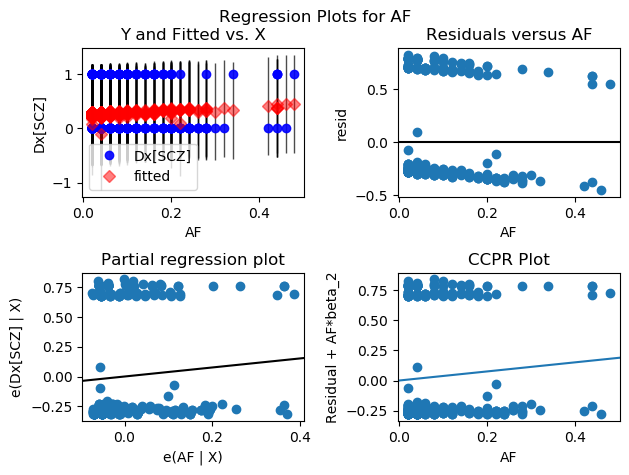

In [16]:
%matplotlib tk
sm.graphics.plot_regress_exog(res_nlm, 'AF')

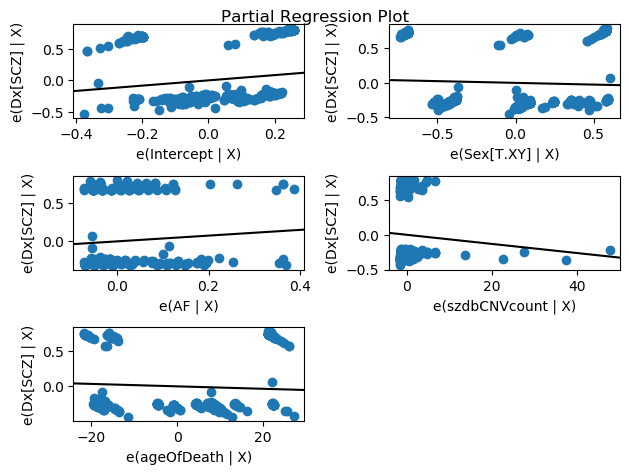

In [17]:
sm.graphics.plot_partregress_grid(res_nlm)
#plot_partregress_grid(res) # this has the same effect

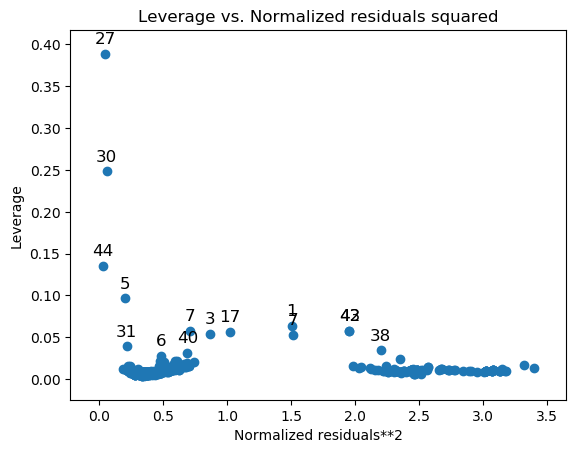

In [21]:
sm.graphics.plot_leverage_resid2(res_nlm)

List graphic objects in `statsmodels`

In [22]:
repr(dir(sm.graphics))

"['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'abline_plot', 'beanplot', 'fboxplot', 'hdrboxplot', 'influence_plot', 'interaction_plot', 'mean_diff_plot', 'plot_ccpr', 'plot_ccpr_grid', 'plot_corr', 'plot_corr_grid', 'plot_fit', 'plot_leverage_resid2', 'plot_partregress', 'plot_partregress_grid', 'plot_regress_exog', 'qqplot', 'rainbow', 'rainbowplot', 'tsa', 'violinplot']"

In [12]:
%connect_info

{
  "shell_port": 43827,
  "iopub_port": 41719,
  "stdin_port": 60403,
  "control_port": 59411,
  "hb_port": 48253,
  "ip": "127.0.0.1",
  "key": "9ab675ef-316c628ad8b99acbfb4de47b",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-dcb71450-cda4-4587-91f9-84bb520a3751.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
